# EXPLORATORY DATA ANALYSIS AND ETL



La primera columna "node" contiene el nombre del nodo en el que se toman los datos (eg c7102). Para los datos de las enfriadoras, aparecen en esta columna como "1" y "2" (enfriadora 1, enfriadora 2 respectivamente) para los datos de temperatura y presión y como "basement" para los datos de consumo (la enfriadora 1 se corresponde con la columna "Power13" y la 2 con "Power14").

La segunda y tercera columna incluyen los rangos de fecha para las series temporales de esa fila. Como se indicó antes, de 2018/01/01 hasta 2021/01/06.

La columna 4 "power": incluye los consumos de los nodos (ie node="cxxxx"). En cada celda se encuentra una serie temporal en formato diccionario en el que la key se corresponde con el timestamp del dato.

Las columnas 5 y 6 'Power13', 'Power14' se corresponden con el consumo de las enfriadoras (medido en los cuadros PM13 PM14) como se indicó en la explicación de la columna nodo. Solo debería tener datos para node="basement". En cada celda se encuentra una serie temporal en formato diccionario en el que la key se corresponde con el timestamp del dato.

Las columnas de la 7 a 10 :'in' -(free cooling)-> 'evaporator' -(compresores)-> 'out'. Y  'ambient' sería la temperatura externa. Estas incluyen las medidas de las temperaturas en las enfriadoras (respectivamente de entrada, salida, en el evaporador y ambiente). Solo debería tener datos para node="1" o "2" dependiendo de que enfriadora se trate. En cada celda se encuentra una serie temporal en formato diccionario en el que la key se corresponde con el timestamp del dato.

Las columnas 11, 12: 'Compressor1', 'Compressor2' son equivalentes al punto 
anterior pero con los datos de presión en cada uno de los dos compresores de cada enfriadora. Solo debería tener datos para node="1" o "2" dependiendo de que enfriadora se trate. En cada celda se encuentra una serie temporal en formato diccionario en el que la key se corresponde con el timestamp del dato.


In [14]:
## Imports
import os
import copy
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Spark dependencies
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import StorageLevel, SparkConf
from pyspark.ml.feature import StandardScaler, VectorAssembler, PCA
from pyspark.mllib.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression
#Other configs
pd.options.display.float_format = '{:.2f}'.format

#Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path+"/datasets"
visualization_path = root_path+"/data_visualization"

In [47]:
#Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path+"/datasets"
visualization_path = root_path+"/data_visualization"

In [2]:
df = spark.read.parquet("output_final.parquet") #Functional programming. Reading the raw data file with the Structured API
df.printSchema()

root
 |-- node: string (nullable = true)
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- power: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Power13: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Power14: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- in: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- out: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- evaporator: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- ambient: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContainsNull = true)
 |-- Compressor1: map (nullable = true)
 |    |-- key: timestamp
 |    |-- value: float (valueContains

In [3]:
df.createOrReplaceTempView("df")

In [22]:
spark.sql("SELECT COUNT(node) from df").show()

+-----------+
|count(node)|
+-----------+
|        291|
+-----------+



In [23]:
spark.sql("SELECT COUNT(DISTINCT(node)) from df").show()

+--------------------+
|count(DISTINCT node)|
+--------------------+
|                 291|
+--------------------+



In [24]:
spark.sql("SELECT node from df").show(291)

+--------+
|    node|
+--------+
|   c6601|
|   c6602|
|   c6603|
|   c6604|
|   c6605|
|   c6606|
|   c6607|
|   c6608|
|   c6609|
|   c6610|
|   c6611|
|   c6612|
|   c6613|
|   c6614|
|   c6615|
|   c6616|
|   c6617|
|   c6618|
|   c6619|
|   c6620|
|   c6621|
|   c6622|
|   c6623|
|   c6624|
|   c6625|
|   c6626|
|   c6627|
|   c6628|
|   c6629|
|   c6630|
|   c6631|
|   c6632|
|   c6633|
|   c6634|
|   c6635|
|   c6636|
|   c6637|
|   c6638|
|   c6639|
|   c6640|
|   c6641|
|   c6642|
|   c6643|
|   c6644|
|   c6645|
|   c6646|
|   c6647|
|   c6648|
|   c6901|
|   c6902|
|   c6903|
|   c6904|
|   c6905|
|   c6906|
|   c6907|
|   c6908|
|   c6909|
|   c6910|
|   c6911|
|   c6912|
|   c6913|
|   c6914|
|   c6915|
|   c6916|
|   c6917|
|   c6918|
|   c6919|
|   c6920|
|   c6921|
|   c6922|
|   c6923|
|   c6924|
|   c6925|
|   c6926|
|   c6927|
|   c6928|
|   c6929|
|   c6930|
|   c6931|
|   c6932|
|   c6933|
|   c6934|
|   c6935|
|   c6936|
|   c6937|
|   c6938|
|   c6939|
|   c6940|

In [25]:
spark.sql("SELECT start_time from df").show()

+-------------------+
|         start_time|
+-------------------+
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-01 01:00:00|
|2018-01-0

In [26]:
spark.sql("SELECT COUNT(start_time) from df").show()

+-----------------+
|count(start_time)|
+-----------------+
|              291|
+-----------------+



In [ ]:
spark.sql("SELECT COUNT(start_time) from df").show()

In [16]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
data = [
    ('2023-07-01 00:00:00', 10),
    ('2023-07-01 00:12:00', 20 ),
    ('2023-07-01 00:15:00', 15),    
    ('2023-07-01 00:30:00', 20),
    ('2023-07-01 00:45:00', 25),
    # Otras filas...
]

df = spark.createDataFrame(data, ["Fecha", "Valor"])

# Convierte la columna 'Fecha' a formato de fecha
df = df.withColumn("Fecha", F.to_timestamp("Fecha"))

# Convierte la columna 'Fecha' a milisegundos unix (bigint)
df = df.withColumn("Fecha_ms", F.unix_timestamp("Fecha") * 1000)

# Define el intervalo de tiempo deseado en milisegundos, en este caso, 30 minutos
intervalo_ms = 30 * 60 * 1000

# Definimos la ventana utilizando la columna de fecha en milisegundos y el intervalo en milisegundos
window_spec = Window.orderBy("Fecha_ms").rangeBetween(-intervalo_ms, 0)

# Agrupamos por ventana y calculamos la media del valor
df_grouped = df.withColumn("Media", F.avg("Valor").over(window_spec))

# Muestra el DataFrame con los valores de la serie temporal agrupados cada 30 minutos
df_grouped.show()

+-------------------+-----+-------------+-----+
|              Fecha|Valor|     Fecha_ms|Media|
+-------------------+-----+-------------+-----+
|2023-07-01 00:00:00|   10|1688162400000| 10.0|
|2023-07-01 00:12:00|   20|1688163120000| 15.0|
|2023-07-01 00:15:00|   15|1688163300000| 15.0|
|2023-07-01 00:30:00|   20|1688164200000|16.25|
|2023-07-01 00:45:00|   25|1688165100000| 20.0|
+-------------------+-----+-------------+-----+



## Ejemplo para una serie temporal concreta (consumo del nodo c6601 en KW)

In [13]:
power_c7102 = spark.sql('''SELECT power FROM df WHERE node LIKE "c7102"''').toPandas()
power_c7102_dict=power_c7102.iloc[0,0]
power_c7102_df = pd.DataFrame([[time, power_c7102_dict[time]] for time in power_c7102_dict.keys()], columns =["date", "value"])
power_c7102_df.sort_values(by="date").head(5)

,date,value
348983,2018-01-01 00:01:06,90.0
545723,2018-01-01 00:02:17,108.0
275932,2018-01-01 00:03:30,90.0
351195,2018-01-01 00:04:42,90.0
1264137,2018-01-01 00:05:54,90.0


In [4]:
power_c6601 = spark.sql('''SELECT power FROM df WHERE node LIKE "c6601"''').collect()

In [6]:
type(power_c6601)

list

In [5]:
power_c6601 = spark.sql('''SELECT power FROM df WHERE node LIKE "c6601"''').toPandas()

In [8]:
power_c6601.head(1)

,power
0,"{2018-07-05 16:38:35: 72.0, 2021-03-14 16:53:0..."


In [8]:
import sys
sys.getsizeof(power_c6601)

41943288

In [6]:
power_c6601_dict=power_c6601.iloc[0,0]

In [7]:
len(power_c6601_dict.keys())

1350950

In [9]:
power_c6601_df = pd.DataFrame([[time, power_c6601_dict[time]] for time in power_c6601_dict.keys()], columns =["date", "value"])

In [11]:
power_c6601_df.date = pd.to_datetime(power_c6601_df.date)

In [12]:
power_c6601_df.sort_values(by="date").head(5)

,date,value
1162874,2018-01-01 00:00:44,54.0
1249322,2018-01-01 00:01:57,54.0
315524,2018-01-01 00:03:09,72.0
375461,2018-01-01 00:04:21,54.0
1247809,2018-01-01 00:05:33,54.0


In [28]:
power_c6601_df.value.describe()

count   1350950.00
mean         94.27
std          38.42
min          54.00
25%          72.00
50%          72.00
75%         108.00
max         378.00
Name: value, dtype: float64

Podemos notar que las fechas estan desordenadas en el .parquet original. Sera conveniente ordenarlo para manipularlo apropiadamente

In [12]:
power_c6601_df.dtypes

date     datetime64[ns]
value           float64
dtype: object

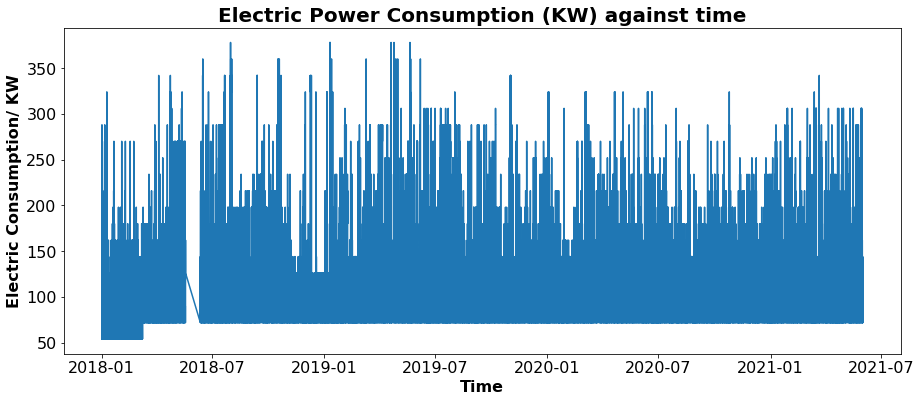

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(power_c6601_df['date'], power_c6601_df['value'] )

ax.set_title('Electric Power Consumption (KW) against time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Electric Consumption/ KW', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

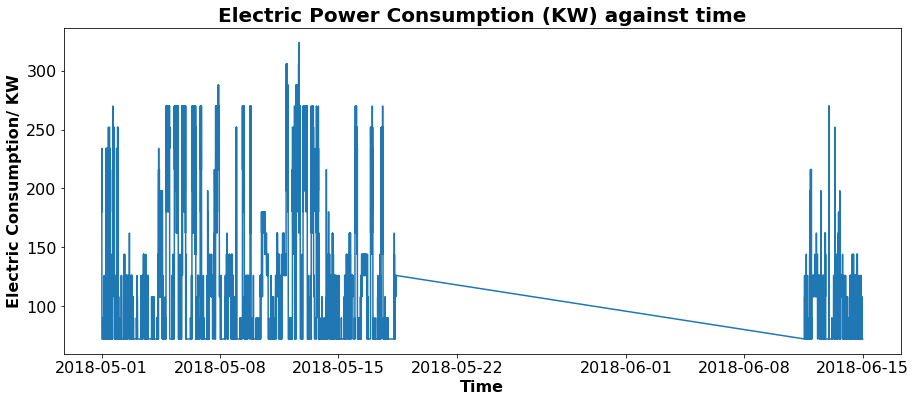

In [15]:
power_c6601_df_subset = power_c6601_df[(power_c6601_df.date>"2018-05-01") & (power_c6601_df.date<"2018-06-15")]
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(power_c6601_df_subset['date'], power_c6601_df_subset['value'] )

ax.set_title('Electric Power Consumption (KW) against time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Time', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Electric Consumption/ KW', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [16]:
power_c6601_df_subset = power_c6601_df[(power_c6601_df.date>"2018-06-15")].reset_index(drop=True)

In [17]:
power_c6601_df_subset

,date,value
0,2018-07-05 16:38:35,72.00
1,2021-03-14 16:53:06,72.00
2,2020-08-13 15:30:12,72.00
3,2018-06-26 07:36:00,108.00
4,2019-12-17 13:29:32,126.00
...,...,...
1185734,2019-09-07 02:20:41,72.00
1185735,2018-07-07 17:38:11,72.00
1185736,2019-06-03 09:48:09,126.00
1185737,2020-12-19 02:05:22,72.00


In [18]:
power_c6601_df_subset.value.isna().sum()

0

In [60]:
#Fuera de esa region donde aparece un outlayer extrano, parece que no tenemos mas problema

Parece haber un mes sin medidas (entre mitad de mayo y mitad de junio de 2018). Vamos a restringir por tanto 

In [64]:
power_c6601_df_subset.to_parquet(data_path+"/03_primary/"+"c6601.parquet")

El Dataset tiene mucha granularidad, vamos a agrupar diariamente para obtener un plot que sea interpretable. Despues, representaremos otro plot de una sola semana con la granularidad original, que junto a los diagramas de cajas y otros indicadores estadisticos, nos permitira entender si existe algun patron con la granularidad original (aproximadamente medidas cada 81 segundos)

In [19]:
power_c6601_df_subset.set_index("date", inplace=True)

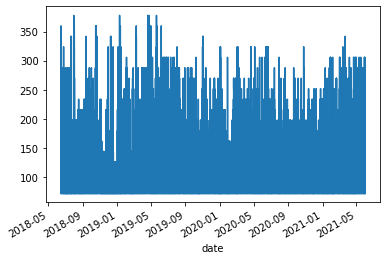

In [20]:
power_c6601_df_subset["value"].plot() # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.show()

In [25]:
power_c6601_df_weekly_sum = power_c6601_df_subset.resample("W").sum()
power_c6601_df_weekly_mean = power_c6601_df_subset.resample("W").mean()
power_c6601_df_daily_sum = power_c6601_df_subset.resample("D").sum()
power_c6601_df_daily_mean = power_c6601_df_subset.resample("D").mean()

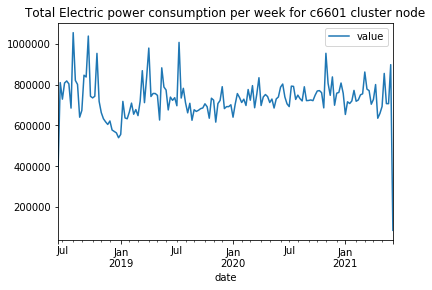

In [22]:
power_c6601_df_weekly_sum.plot()
plt.title("Total Electric power consumption per week for c6601 cluster node")
plt.show()

No se observa una tendencia clara pero si ciclos y se puede intuir que estacionalidad tambien

Caida muy extrana la ultima semana

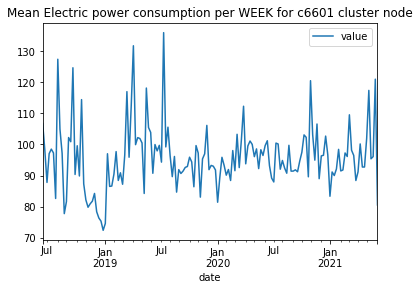

In [23]:
power_c6601_df_weekly_mean.plot()
plt.title("Mean Electric power consumption per WEEK for c6601 cluster node")
plt.show()

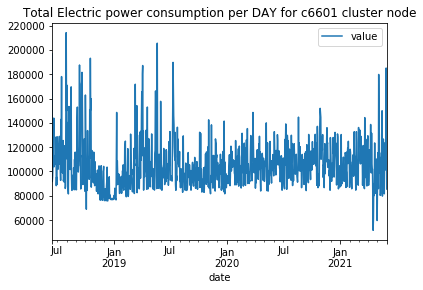

In [26]:
power_c6601_df_daily_sum.plot() #Parece el mas razonable de tomar
plt.title("Total Electric power consumption per DAY for c6601 cluster node")
plt.show()

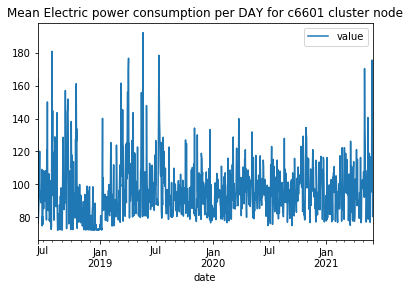

In [24]:
power_c6601_df_daily_mean.plot()
plt.title("Mean Electric power consumption per DAY for c6601 cluster node")
plt.show()

## Working with the last 2 years on daily aggregation


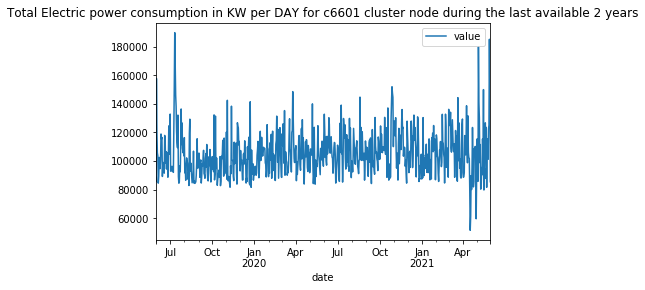

In [41]:
power_c6601_df_2years = power_c6601_df[(power_c6601_df.date>"2019-05-30")].reset_index(drop=True).sort_values(by="date")
power_c6601_df_2years.set_index("date", inplace=True)
power_c6601_df_2years_daily_sum = power_c6601_df_2years.resample("D").sum()
power_c6601_df_2years_daily_sum.plot()
plt.title("Total Electric power consumption in KW per DAY for c6601 cluster node during the last available 2 years")
plt.show()

In [42]:
power_c6601_df_2years_daily_sum.reset_index(inplace=True)

In [43]:
power_c6601_df_2years_daily_sum

,date,value
0,2019-05-30,88596.00
1,2019-05-31,85644.00
2,2019-06-01,157680.00
3,2019-06-02,119988.00
4,2019-06-03,105696.00
...,...,...
728,2021-05-27,122310.00
729,2021-05-28,125118.00
730,2021-05-29,185058.00
731,2021-05-30,144054.00


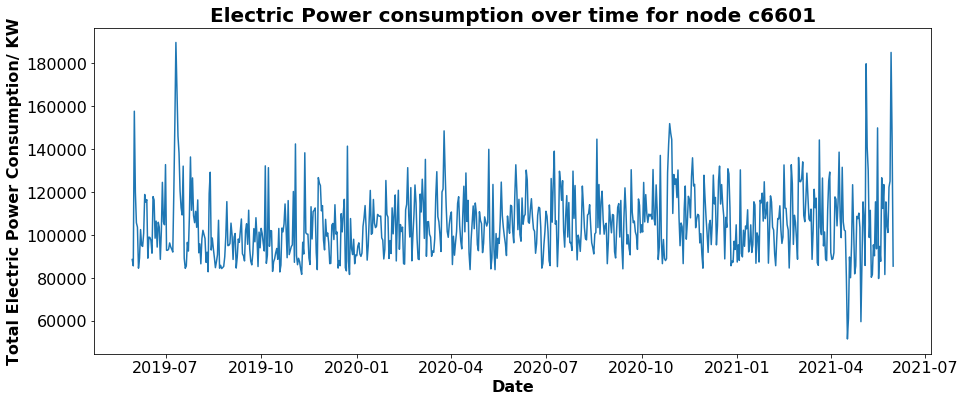

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(power_c6601_df_2years_daily_sum['date'], power_c6601_df_2years_daily_sum['value'] )

ax.set_title('Electric Power consumption over time for node c6601', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Total Electric Power Consumption/ KW', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.savefig(visualization_path+"/c6601_daily_last2years_ts.svg", format="svg",dpi =600)
plt.show()
plt.close()

Not clear trend (still might make Augmented Dickey Fueller test). Cyclic behavior, seasonal component???

## Conclusiones rapidas

Tenemos 288 nodos, 2 consumos de enfriadoras y basement(?)

Las columnas start y end time contienen todo el rato mismo valor


## Funciones rapidas a sucio


In [23]:
dummy_dict={"a":1, "b": 2}
pd.DataFrame([[key, dummy_dict[key]] for key in dummy_dict.keys()], columns =["date", "value"])

,date,value
0,a,1
1,b,2
